# SpykProps

This Jupyter notebook is an overview of the main functions from `SpykProps`. 

*Author: Joan Barreto Ortiz (jbarreto@umn.edu)*

**Load libraries**

In [1]:
import SpykFunctions as SF
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.dpi']= 200
plt.rcParams["axes.grid"] = False


**List files**

In [2]:
images_path = r'./Images'
Images = SF.ListImages(images_path, imgformat=".tif", recursive=False)

**Read and visualize an image**

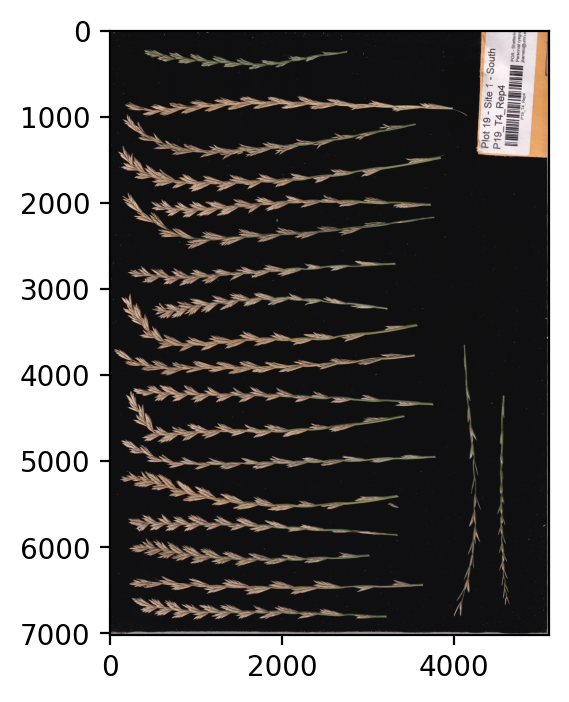

In [3]:
img = plt.imread(Images[0])
plt.imshow(img)

# Spike Segmentation

This function takes an image array (or path to image) and outputs a list with segmented spikes (masks). 

There are two methods for spike segmentation:
- **Otsu**: estimates the threshold on a gray image using Otsu's algorithm. It requires a scaling parameter (`OtsuScaling`) from zero (no threshold) to one (no scaling) for the estimated threshold.
- **Color thresholding**: requires a list with the channel and threshold to segment the spike. E.g. `channel_thresh=[0,30]` keeps pixel values greater than 30 on the 0th (red) channel. 

Images can be resized using the `rescale_rgb` parameter. E.g. `rescale_rgb=0.5` resizes both the horizontal and vertical axes by half. Rescaling values lower than 0.5 may affect spikelet segmentation.

The parameters with the suffix `_out` specify which masks will be appended to the output `I`, which is a list.

The parameter `crop_coord` takes a list with coordinates to crop the images if required.


## Full image
Segments all spikes in original image. 


CPU times: user 7.05 s, sys: 1.93 s, total: 8.99 s
Wall time: 6.25 s


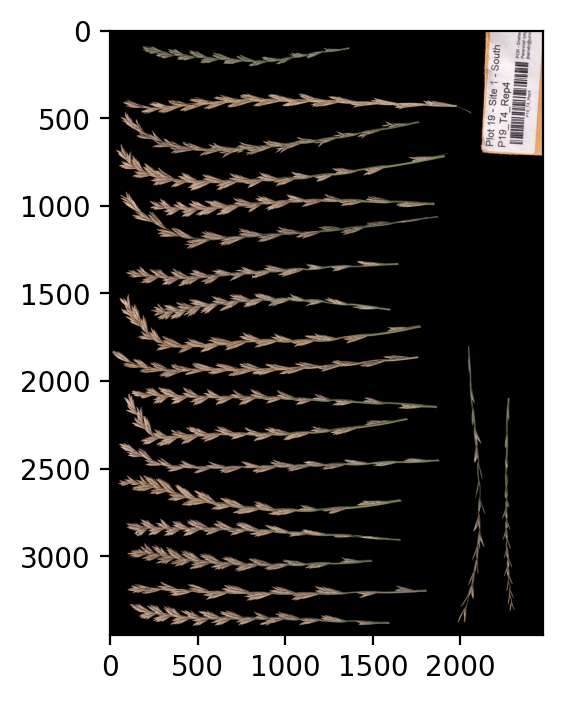

In [4]:
%%time

I = SF.spike_segm(Images[0], rescale_rgb=0.5, channel_thresh=[0,30], rgb_out=True, 
               gray_out=True, lab_out=True, hsv_out=True, bw_out=True,
              crop_coord=[44,6940,25,4970])
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

### Enumerate spikes

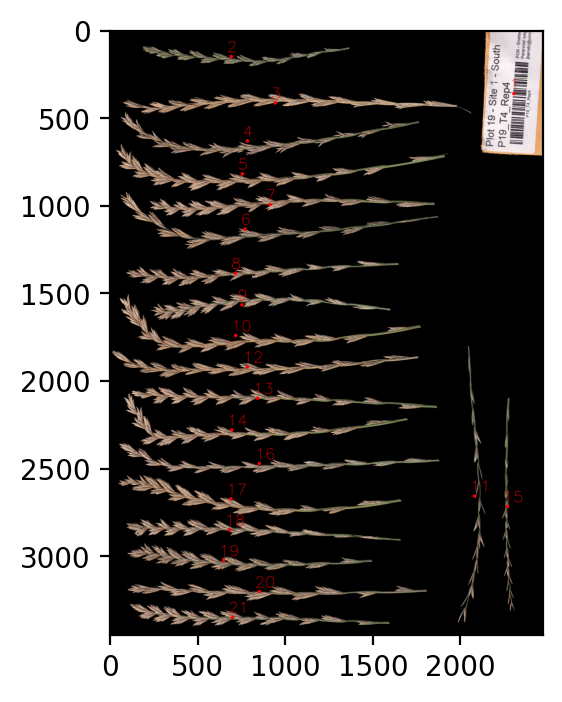

In [5]:
SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False)

## Single spike
Select an area for a particular spike

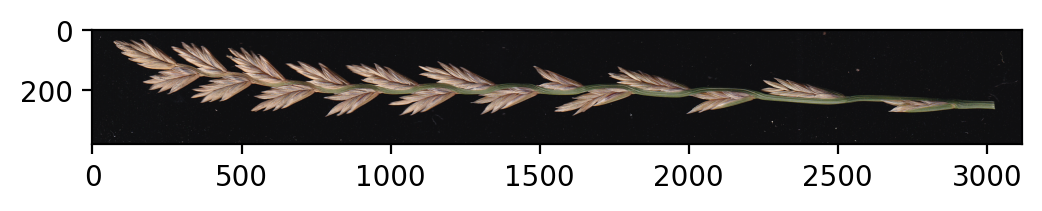

In [6]:
# img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike
# img0 = img[3500:6930, 3900:4400, :]    # Single vertical spike

plt.imshow(img0)

### Otsu
Sccaling by 30% (`OtsuScaling=0.3`)

CPU times: user 1.16 s, sys: 385 ms, total: 1.55 s
Wall time: 433 ms


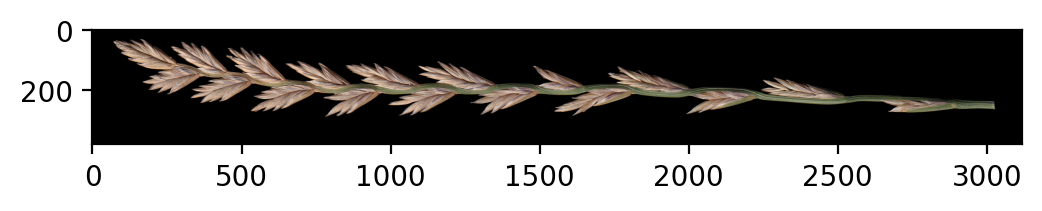

In [7]:
%%time

I = SF.spike_segm(img0, OtsuScaling=0.3, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

### Channel-Threshold 
Keep pixel values greater than 30 on the 0th (red) channel.

CPU times: user 949 ms, sys: 301 ms, total: 1.25 s
Wall time: 384 ms


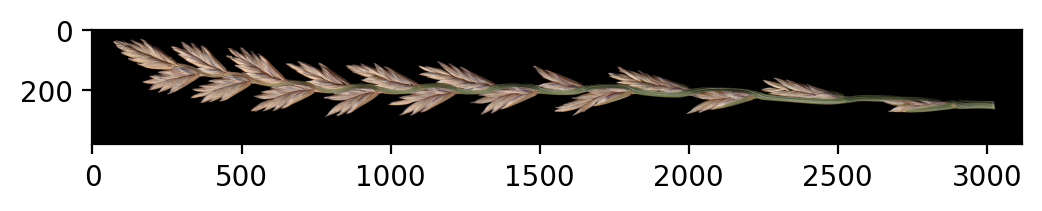

In [8]:
%%time
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

# Color distribution across spikes

The function `PixelHist` allows to see the distribution of pixel values across spikes for a given channel.

The function requires a binary mask (`bw`), colored mask (`ColorSpace`), and the channel (`channel`) to evaluate. The spikes (`spikes`) can be specified with a list. The output is an overlapping histogram per spikes. The number of bin (`nbins`) can be specified.

## Subset, segment, and enumerate spikes

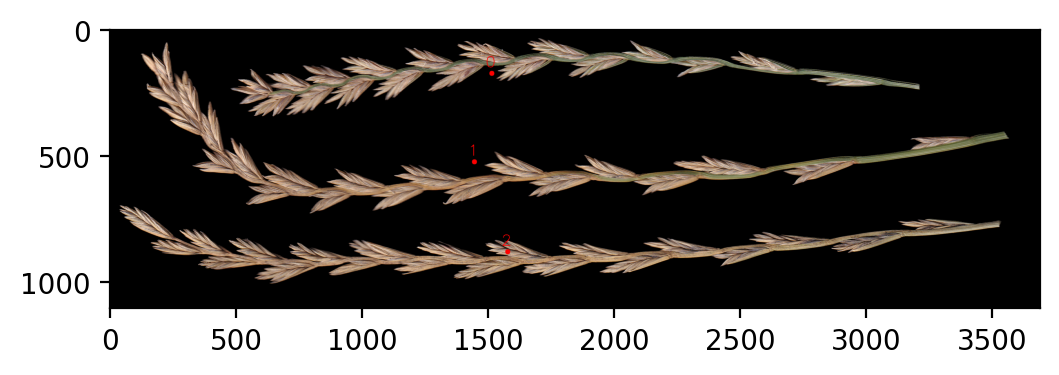

In [9]:
# Subset
img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes
# plt.imshow(img0)

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]
# plt.imshow(rgb0)

# Enumerate
SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False, BaseZero=True)

## Plot pixel-values distributions
The example below shows the distribution of 'a' values (a green-to-red scale from the CIELab scale) for spikes 0 (red), 1 (green), and 2 (blue). The inserted box shows the spike's area and its mean intensity value for the given channel.



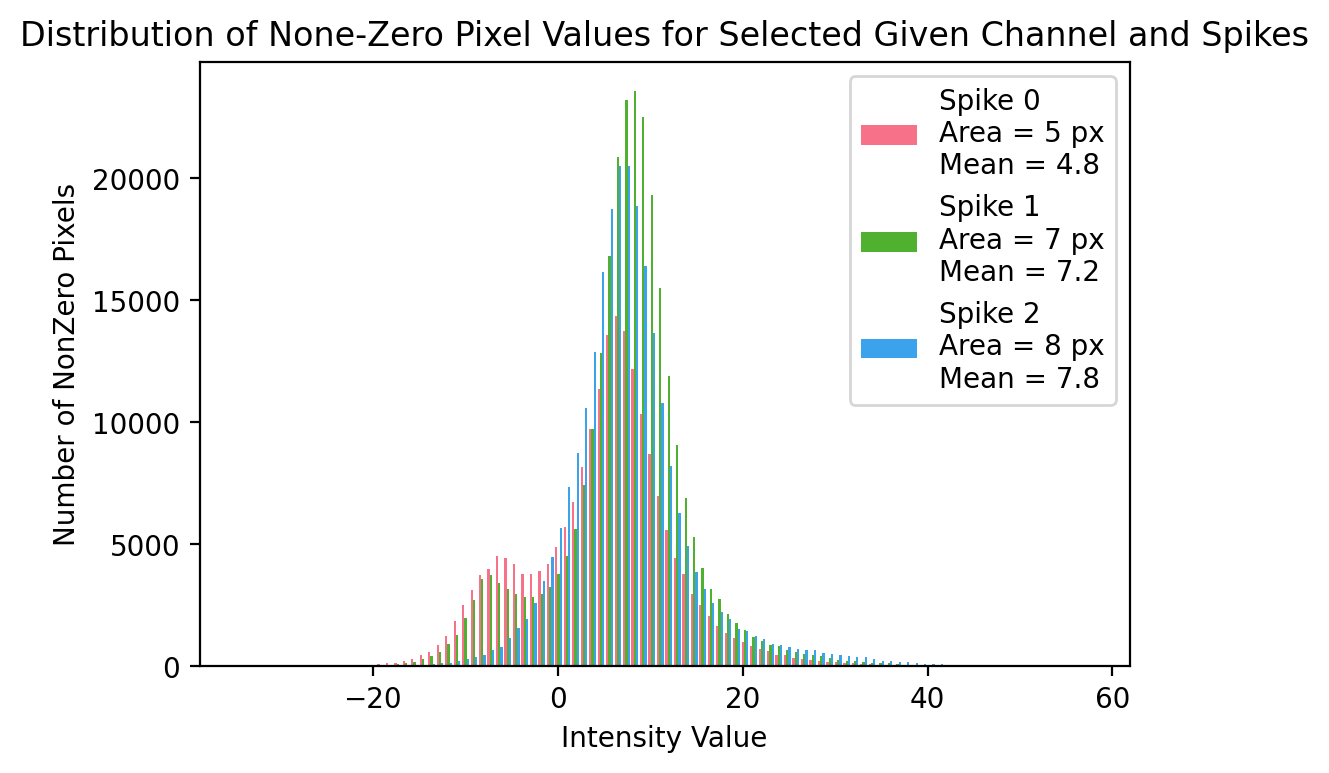

In [10]:
SF.PixelHist(bw=bw0, ColorSpace=lab0, channel = 1, spikes=[0,1,2], nbins = 100)

# Spike Length

This function takes a spike's binary mask and approximates its length given a method. The `Method` options include bounding box (`bbox`), convex hull (`chull`), and the two current skeletonization methods available by *scikit-image*'s `skeletonize` function (see https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.skeletonize). The medial axis method (`skel_ma`) is more accurate but also more computationally intensive. 

## Single method

The two outputs are 
- an integer with the length in pixels, and
- an image object with the overlay (if `Overlay=True`)

In [11]:
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel_ma', Overlay=True)

print("This spike's length is", SL, "pixels.")

This spike's length is 2864 pixels.


## All methods

`Method='all'` requires `Overlay=False`, and returns:
- a dataframe with the lengths across methods
- a dataframe with the time to compute each method

The lengths can also be computed in batch using the `LengthBatch()` function, which only requires a path to the images.

In [12]:
Lengths,Time = SF.spk_length(bw0, Method='all', Overlay=False)

### Lengths

In [13]:
Lengths

,bbox,chull,skel_Lee,skel
0,3054.0,2949.0,2864.0,3143.0


### Time

In [14]:
Time

,bbox,chull,skel_Lee,skel
0,0.01,0.17,0.24,0.36


# Elliptical Fourier Descriptors

The `efd` function tales a binary mask of a spike as input and returns the Elliptical Fourier descriptors (efd), using the `spatial_efd` package (see https://pypi.org/project/spatial-efd/).

While the number of harmonics (`n_harmonics`) is required, `efd` also returns the maximum number of harmonics that can be computed for a given contour (Nyquist Frequency), as the last variable in the resulting dataframe.

If `efd_filename` is specified, the plot with the outline will be saved as a .png file with the same name, followed by an underscore and the number of harmonics. E.g. if `efd_filename='./EFD_plot'` and `n_harmonics=30`, the plot will be saved as './EFDplot_30.png'. If the `efd_filename=None`, the plot will be returned in the console.


CPU times: user 958 ms, sys: 277 ms, total: 1.24 s
Wall time: 1.23 s


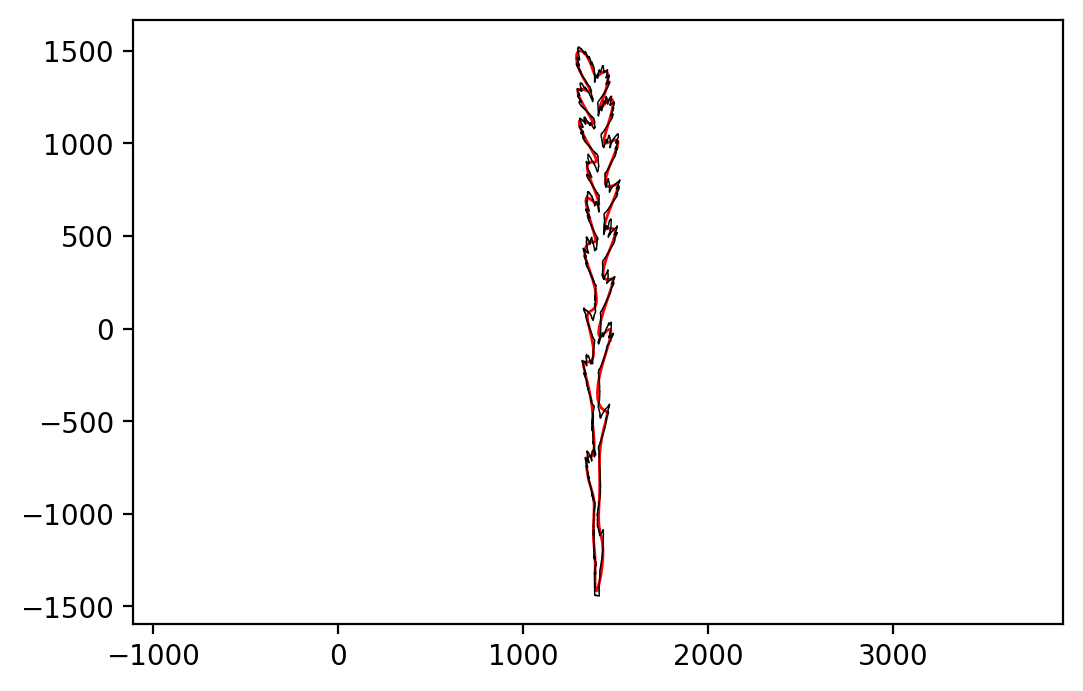

In [15]:
%%time
efd_data = SF.efd(bw0, n_harmonics=30, plot_efd=True, efd_filename=None)

In [16]:
efd_data

,An1,Bn1,Cn1,Dn1,An2,Bn2,Cn2,Dn2,An3,Bn3,...,Dn28,An29,Bn29,Cn29,Dn29,An30,Bn30,Cn30,Dn30,Min_Coeffs
0,1.0,-7.853388e-18,1.884813e-17,0.051959,-0.133648,0.020026,-0.017005,0.011499,0.126568,-0.024768,...,-0.000531,-0.003677,0.004106,-0.001395,0.001638,0.001787,-0.003882,-0.001194,-0.001058,81


# Spikes dataframe
The function `SpikesDF` requires the list of masks returned by the `spike_segm`  function, and the image's path. The output is a dataframe with the image name, spike ID, and both geometric (except for length and EFD) and color properties.

In [17]:
%%time

# Subset
img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes

# Spike segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

# Enumerate
# SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False, BaseZero=True)

df = SF.SpikesDF(I=I, ImagePath='image_path')
df

CPU times: user 3.22 s, sys: 722 ms, total: 3.94 s
Wall time: 1.92 s


,Image_Name,Spike_Label,Area,MajorAxis,MinorAxes,Orientation,Eccentricity,Perimeter,Circularity,Red_mean,...,S_sd,S_Min,S_Max,V_p25,V_p50,V_p75,V_Mean,V_sd,V_Min,V_Max
0,image_path,1,207007,2836.580675,221.870431,-1.529619,0.996936,16460.405907,0.009601,147.915583,...,0.182264,0.090909,0.692857,0.478431,0.603922,0.717647,0.589205,0.169053,0.274510,0.831373
1,image_path,2,280762,3834.246943,497.905399,1.530198,0.991533,16042.213952,0.013709,153.080702,...,0.169058,0.134146,0.693750,0.494118,0.627451,0.725490,0.604065,0.169753,0.286275,0.850980
2,image_path,3,247718,3748.905530,207.951694,-1.554719,0.998460,21104.869253,0.006989,154.013091,...,0.191617,0.114407,0.780236,0.505882,0.635294,0.733333,0.608190,0.174141,0.258824,0.847059


The following standarizes each variable across spikes and retuns a heatmap to visualize their differences.

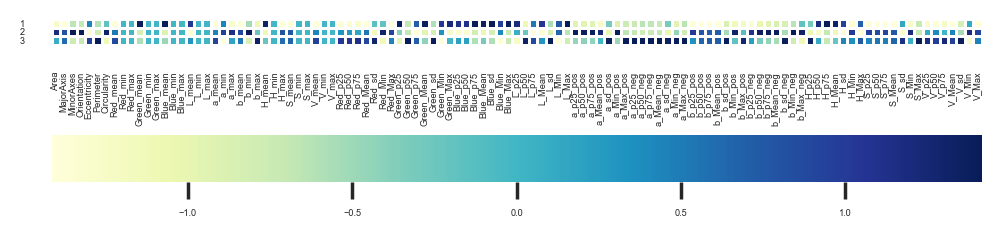

In [18]:
df_std = df.iloc[:,2:]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_std)
df_std = pd.DataFrame(x_scaled, columns=df.columns[2:], index=df.index)

sns.set(font_scale=0.3)
ax = sns.heatmap(df_std, linewidths=.5,
                 cmap='YlGnBu',
                 xticklabels=list(df_std.columns),
                 yticklabels=df.Spike_Label,
                 cbar_kws={"orientation": "horizontal"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")

# Spikelet Segmentation

This function takes an RGB mask for a single spike and outputs, respectively:
- a labeled image with the detected spikelets, 
- geometric properties of fitted ellipses per spike, and 
- an image of the fitted ellipses and the estimated spikelet's angle.

Adding a pad around the spike improves spikelet segmentation. For spikes from the original 7016x5104 (length x width) images, `Pad=200` works well.

The `MinDist` argument refers to the expected minimum distance (in pixels) between spikelets. For 7016x5104 (length x width) images, `MinDist=50` seems to work well overall. For images rescaled to 0.5 and 0.75, `MinDist=40` was better.

`data_out=True` returns a dataframe with the ellipses' ID, Angle (approximation of spikelet angle), Area, Length, and centroid. `plot_ellipse=True` returns an image of the spike with the fitted ellipses and angles, each with a different color, and adds the ID number if `Numbered=True`. The image can be printed is returned to the console (`img_out=False`) or as an object in the Python environment (`img_out=True`). To visually assess the watershed segmentation, the previous image parameters must be set to `False` and `plot_segmented=False`.



In [19]:
plt.rcParams["axes.grid"] = False

# subset single spike
img0 = img[6550:6930, 180:3300, :] 

# Spike segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

# Spikelet segmentation
Spikelets,EllipseData,Spikelets_Image = SF.spikelet_segm(cropped_rgb=rgb0,Pad=200,MinDist=50,data_out=True,
                            plot_ellipse=True,Numbered=True,img_out=True,plot_segmented=False)

## Labeled spikelets

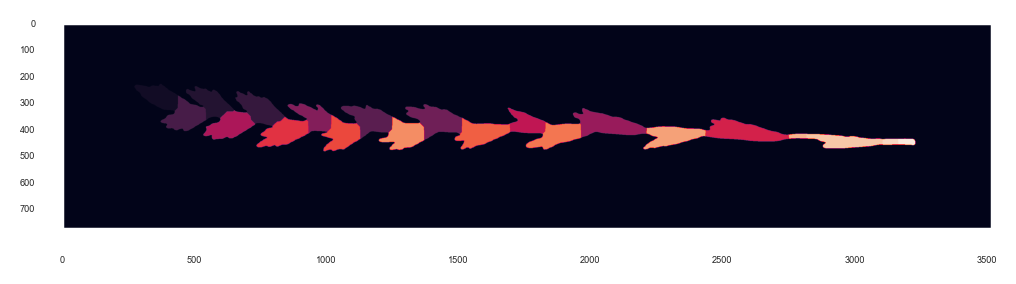

In [20]:
plt.imshow(Spikelets)

## Ellipses' data

In [21]:
EllipseData

,Ellipse_Number,Ellipse_Angle,Ellipse_Area,Ellipse_Length,Ellipse_Centroid
0,1,22.905899,45069.897969,186,"[373, 282]"
1,2,32.709389,51734.897241,180,"[562, 304]"
2,3,31.334106,54718.200976,194,"[749, 328]"
3,4,173.572830,58346.860885,156,"[460, 351]"
4,5,14.661606,64062.364891,187,"[1161, 370]"
5,6,13.016273,77116.553975,210,"[1410, 374]"
6,7,26.070892,48513.379163,175,"[953, 360]"
7,8,8.746750,82834.128585,276,"[2053, 387]"
8,9,160.310913,53123.924116,198,"[639, 389]"
9,10,24.290688,41530.681188,164,"[1757, 382]"


## Fitted ellipses and angles

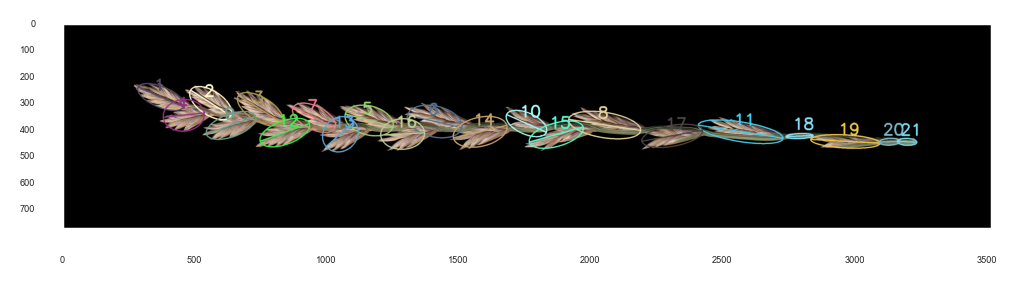

In [22]:
plt.imshow(Spikelets_Image)

## Distances Between Spikelets

The `EucDist()` requires the ellipses data from the `spikelet_segm()` function, and returns the Euclidean distance between all detected spikelets. The distance will be returned in pixels or as a proportion from the spike length (from `spk_length()`) is passed to the argument `spike_length`. 

The output is a diagonal matrix with the spikelets' (ellipses') ID as rows and columns.

A heatmap can be returned if `HeatMap=True`.

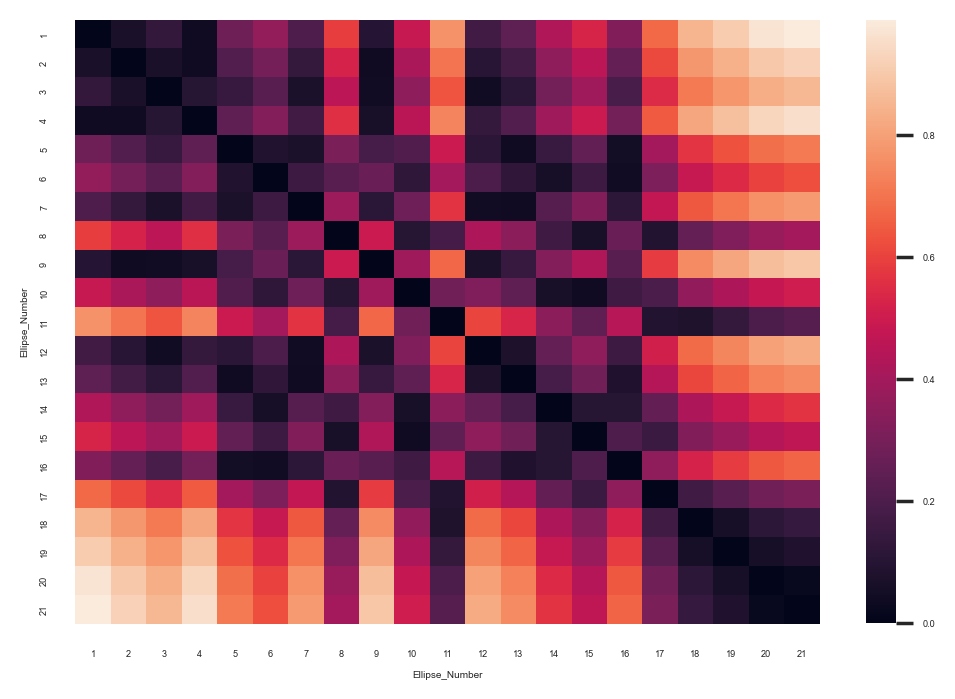

In [23]:
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel_ma', Overlay=True)

# Euclidean distance
D = SF.DistAll(EllipseData=EllipseData, HeatMap=True, spike_length=SL)

In [24]:
D

Ellipse_Number,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Ellipse_Number,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.066437,0.132264,0.038771,0.276850,0.363503,0.204337,0.587737,0.100110,0.484500,...,0.170310,0.242410,0.424608,0.525042,0.323149,0.677897,0.845832,0.906556,0.965122,0.988146
2,0.066437,0.000000,0.065829,0.039214,0.210414,0.297096,0.137915,0.521407,0.040046,0.418136,...,0.105297,0.176320,0.358173,0.458622,0.256762,0.611521,0.779505,0.840214,0.898793,0.921821
3,0.132264,0.065829,0.000000,0.101227,0.144600,0.231354,0.072100,0.455773,0.043918,0.352460,...,0.044705,0.111104,0.292362,0.392843,0.190979,0.545811,0.713860,0.774547,0.833143,0.856176
4,0.038771,0.039214,0.101227,0.000000,0.244852,0.331801,0.172166,0.556357,0.063893,0.452992,...,0.135297,0.208532,0.392357,0.492978,0.290137,0.646160,0.814352,0.874971,0.933601,0.956643
5,0.276850,0.210414,0.144600,0.244852,0.000000,0.086953,0.072710,0.311509,0.182383,0.208143,...,0.112535,0.041853,0.147762,0.248273,0.047785,0.401349,0.569507,0.630143,0.688765,0.711805
6,0.363503,0.297096,0.231354,0.331801,0.086953,0.000000,0.159642,0.224557,0.269255,0.121191,...,0.198865,0.125772,0.061580,0.161561,0.045650,0.314462,0.482575,0.543229,0.601842,0.624880
7,0.204337,0.137915,0.072100,0.172166,0.072710,0.159642,0.000000,0.384194,0.110103,0.280831,...,0.043410,0.041083,0.220401,0.320960,0.118893,0.474059,0.642212,0.702852,0.761473,0.784512
8,0.587737,0.521407,0.455773,0.556357,0.311509,0.224557,0.384194,0.000000,0.493716,0.103367,...,0.422956,0.349376,0.164706,0.065190,0.267373,0.090525,0.258099,0.318822,0.377387,0.400415
9,0.100110,0.040046,0.043918,0.063893,0.182383,0.269255,0.110103,0.493716,0.000000,0.390371,...,0.071504,0.145012,0.329366,0.429992,0.226881,0.583260,0.751526,0.812072,0.870721,0.893768
